In [5]:
import pandas as pd
import numpy as np
cwwb=pd.DataFrame()
gljy=pd.DataFrame()
for i in range(2011,2019):
    tmp=pd.read_excel('./财务舞弊相关数据/fraud'+str(i)+'.xlsx',sheet_name=0)
    tmp['year']=i
    cwwb=pd.concat([tmp,cwwb],ignore_index=True)
    gljy=pd.concat([pd.read_excel('./关联交易双方数据/RPT'+str(i)+'.xlsx'),gljy],ignore_index=True)
cwwb['node']=[str(cwwb.loc[i,'year'])+'company'+str(cwwb.loc[i,'code']) for i in cwwb.index]
gljy['inNode']=[gljy.loc[i,'publish_date'][0:4]+'company'+str(gljy.loc[i,'trading_code']) for i in gljy.index]
gljy['outNode']=[gljy.loc[i,'publish_date'][0:4]+'company'+str(gljy.loc[i,'rela_stockid']) for i in gljy.index]

split1 :

best val auc:0.

In [130]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta
        Args:
        ----------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                输出特征维度
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency, input_feature):
        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        device = "cuda" if torch.cuda.is_available() else "cpu"
        support = torch.mm(input_feature, self.weight.to(device))
        output = torch.sparse.mm(adjacency, support)
        if self.use_bias:
            output += self.bias.to(device)
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

# ## 模型定义
class GcnNet(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, input_dim=343,drop_out=0.1,embed_dim=1024):
        super(GcnNet, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, embed_dim)
        self.gcn2 = GraphConvolution(embed_dim, embed_dim)
        self.mlp=nn.Linear(embed_dim,embed_dim)
        self.output=nn.Linear(embed_dim,2)
        
        self.layer_norm=nn.LayerNorm(normalized_shape= embed_dim)
    def forward(self, adjacency, feature,drop_out=0.5):
        self.dropout = nn.Dropout(p=drop_out)
        h1 = F.relu(self.dropout(self.gcn1(adjacency, feature)))
        h2 = F.relu(self.dropout(self.gcn2(adjacency, h1)))
        h2=self.layer_norm(h2)
        h3=torch.sigmoid(self.dropout(self.mlp(h2)))
        logits=self.output(h3)
        return logits
    
from sklearn.metrics import roc_auc_score
class myGCN:
    def __init__(self,print_flag=False,early_stopping=True,seed=55):
        self.printFlag=print_flag
        self.early_stopping=early_stopping
        flag = torch.cuda.is_available()
        print(flag)
        ngpu= 1
        # Decide which device we want to run on
        self.device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
        print(self.device)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        pass
    def fit(self,adj,features,labels,train_mask,val_mask,test_mask,learning_rate=0.01,epochs=2000,weight=[1.0,2.0],l2_ratio=0.001,
                dropout=0.2,min_epoch=1000,max_train_auc=0.99,min_train_auc=0.90,tolerance=200,embed_dim=1024):
        weight_decay = l2_ratio
        sample_size=features.size()[0]
        feature_size=features.size()[1]
        # 模型定义：Model, Loss, Optimizer
        device = self.device
        self.model = GcnNet(input_dim=feature_size,embed_dim=embed_dim).to(device)
        self.criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(weight,requires_grad=False).to(device))
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.dropout=dropout
        self.tensor_x = features.to(device)
        self.tensor_y = labels.to(device)
        tensor_train_mask = torch.from_numpy(train_mask).to(device)
        tensor_test_mask = torch.from_numpy(test_mask).to(device)
        tensor_val_mask=torch.from_numpy(val_mask).to(device)
        indices = torch.from_numpy(np.asarray([adj.row, adj.col]).astype('int64')).long()
        values = torch.from_numpy(adj.data.astype(np.float32))
        
        self.tensor_adjacency = torch.sparse.FloatTensor(indices, values, (sample_size,sample_size)).to(device)
        ###train
        train_loss,train_auc,val_auc,test_auc,best_e,best_val_auc=self.train(tensor_train_mask,tensor_val_mask,tensor_test_mask,epochs,min_epoch,max_train_auc,min_train_auc,tolerance)
        return train_loss,train_auc,val_auc,test_auc,best_e,best_val_auc
    def train(self,tensor_train_mask,tensor_val_mask,tensor_test_mask,epochs,min_epoch=1000,max_train_auc=0.98,min_train_auc=0.95,tolerance=200):
        loss_history = []
        val_auc_history = []
        train_auc_history=[]
        test_auc_history=[]
        self.model.train()
        train_y = self.tensor_y[tensor_train_mask]
        stop_increasing=0
        max_auc=0
        train_auc_min_id=0
        for epoch in range(epochs):
            logits = self.model(self.tensor_adjacency, self.tensor_x,drop_out=self.dropout)  # 前向传播
            train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
            loss = self.criterion(train_mask_logits, train_y)    # 计算损失值
            self.optimizer.zero_grad()
            loss.backward()     # 反向传播计算参数的梯度
            self.optimizer.step()    # 使用优化方法进行梯度更新
            train_acc, _, _ = self.test(tensor_train_mask,drop_out=self.dropout)     # 计算当前模型训练集上的准确率
            val_acc, _, _ = self.test(tensor_val_mask,drop_out=0.0)     # 计算当前模型在验证集上的准确率
            test_acc, _, _ = self.test(tensor_test_mask,drop_out=0.0) 
            # 记录训练过程中损失值和准确率的变化，用于画图
            loss_history.append(loss.item())
            val_auc_history.append(val_acc.item())
            train_auc_history.append(train_acc.item())
            test_auc_history.append(test_acc.item())
            if train_acc>min_train_auc and train_auc_min_id==0:
                train_auc_min_id=epoch
                print('epoch {} meet the min train auc requirement'.format(epoch))
            if train_acc>=max_train_auc:
                print('train auc meets the setting line:{}'.format(max_train_auc))
                break
            if epoch>min_epoch and val_acc.item()<max_auc:
                stop_increasing+=1
            else:
                max_auc=val_acc.item()
                stop_increasing=0
            if self.early_stopping:
                if stop_increasing>=tolerance:
                    if self.printFlag:
                        print('验证集收敛:epoch {}'.format(epoch))
                    break
            if epoch%100==0 and self.printFlag:
                print("Epoch {:03d}: Loss {:.4f}, TrainAuc {:.4}, ValAuc {:.4f}".format(
                    epoch, loss.item(), train_acc.item(), val_acc.item()))
        if self.early_stopping==True:
            best_e=np.argmax(val_auc_history[min_epoch:])+min_epoch+1
            best_val_auc=max(val_auc_history[min_epoch:])
        else:
            best_e=np.argmax(val_auc_history[train_auc_min_id:])+train_auc_min_id+1
            best_val_auc=max(val_auc_history[train_auc_min_id:])
        return loss_history,train_auc_history, val_auc_history,test_auc_history,best_e,best_val_auc
# 测试函数
    def test(self,mask,drop_out=0.1):
        self.model.eval()
        with torch.no_grad():
            logits = self.model(self.tensor_adjacency, self.tensor_x,drop_out=drop_out)
            test_mask_logits = torch.softmax(logits[mask],dim=1)
            predict_y = test_mask_logits[:,1]
            auc = roc_auc_score(self.tensor_y[mask].cpu().numpy(),predict_y.cpu().numpy())
        return auc, test_mask_logits.cpu().numpy(), self.tensor_y[mask].cpu().numpy()

best result for GCN: val auc 0.7116

In [131]:
import pandas as pd
import numpy as np
import csv
node_embedding=np.load('./data_preprocessing/dglke_result/ComplEx_KG5_3/KG5_ComplEx_entity.npy')
node_dict=pd.read_csv('./data_preprocessing/dglke_dataset/KG5/entities.tsv',header=None,sep='\t',quoting=csv.QUOTE_NONE,index_col=1).to_dict()[0]
data=pd.read_csv('./data_preprocessing/RT_SC_B_features_v2.csv')

In [132]:
from tqdm import tqdm
embed_dim=node_embedding.shape[1]
new_col=list(range(0,embed_dim))
for i in tqdm(data.index):
    node=str(data.loc[i,'year'])+'.comp.'+ str(data.loc[i,'Stkcd'])
    data.loc[i,new_col]=node_embedding[node_dict[node],:]

100%|██████████| 9366/9366 [01:53<00:00, 82.54it/s]


In [32]:
adj_matrix=sp.csr_matrix(pd.read_csv('./data_preprocessing/RT_SC_adj.cav').values)

In [136]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import torch
import math
from sklearn.preprocessing import LabelBinarizer
import random
from sklearn.model_selection import train_test_split,KFold

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    
    return np.array(mask, dtype=bool)

def normalize_adj(adjacency):
  adjacency += 0.0001*sp.eye(adjacency.shape[0])
  degree = np.array(adjacency.sum(1))
  d_hat = sp.diags(np.power(degree, -0.5).flatten())
  return (d_hat.dot(adjacency).dot(d_hat)+sp.eye(adjacency.shape[0])).tocoo()
def normalize_features(features):
  return features / features.sum(1)
def load_data(X,y,adj_matrix,train_ratio=0.7,test_ratio=0.1):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...')
    idx_features_labels = X.copy()

    features = sp.csr_matrix(idx_features_labels, dtype=np.float32)
    labels =y.copy()

    # build graph
    
    adj = sp.coo_matrix(adj_matrix, dtype=np.float32)


    #features = normalize_features(features)
    adj = normalize_adj(adj)


    features = torch.FloatTensor(features.todense())
    labels = torch.LongTensor(labels)
    print('finished')
    return adj, features, labels

data=pd.read_csv('./data_preprocessing/RT_SC_B_features_v2.csv')
financial_featrues=data
X=financial_featrues.drop(['year','Stkcd','IndustryCode','label','EquityNatureID'],axis=1)
for column in list(X.columns[X.isna().sum() > 0]):
    mean_val = X[column].mean()
    X[column].fillna(mean_val, inplace=True)

#adj_matrix=sp.load_npz('./data_preprocessing/RT_SC_B_v3.npz')
X=X.values
from sklearn.preprocessing import minmax_scale
X=minmax_scale(X)
y=financial_featrues['label'].values
adj, features, labels=load_data(X,y,adj_matrix)

Loading {} dataset...
finished


In [5]:
from tqdm import tqdm
sm_csv=pd.read_csv('./data_preprocessing/comp_relations/sameManager.csv')
sm=np.zeros([9366,9366])
node=pd.read_csv('./data_preprocessing/comp_relations/node_list.csv',index_col='0').to_dict(orient='index')
for i in tqdm(sm_csv.index):
    a=node[sm_csv.loc[i,'comp1']]['index']
    b=node[sm_csv.loc[i,'comp2']]['index']
    w=sm_csv.loc[i,'w']
    if a!=b:
        sm[a,b]=w
        sm[b,a]=w
        


100%|██████████| 30644/30644 [00:00<00:00, 57200.34it/s]


In [7]:
sm=sp.csr_matrix(sm)
sp.save_npz('./data_preprocessing/comp_relations/sdse.npz',sm)

In [133]:
import scipy.sparse as sp

rpt=sp.load_npz('./data_preprocessing/comp_relations/rpt.npz')
sc=sp.load_npz('./data_preprocessing/comp_relations/sc.npz')
sdse=sp.load_npz('./data_preprocessing/comp_relations/sameManager.npz')
sdse2=sp.load_npz('./data_preprocessing/comp_relations/sdse_sameyear.npz')
adj_matrix=sdse
#adj_matrix2=sp.load_npz('./data_preprocessing/RT_SC_B_v3.npz')


In [51]:
sdse[0,3]

5

In [52]:
sdse2[0,3]

0.0

In [ ]:
from tqdm import tqdm
node_num=len(features)
kf=KFold(5,shuffle=True,random_state=5)
val_auc=[]
test_auc=[]
parmas=[]
leanring_rate=[0.1,0.01,0.05]
l2=[0.0001,0.001,0]
weight=[[1.0,1.0],[1.0,2.0],[1.0,3.0],[1.0,4.0]]
for l in l2:
    for w in weight:
        for lr in leanring_rate:
            parmas.append([lr,w,l])
k=0
for train_ids,test_ids in kf.split(features,groups=financial_featrues['label'].values):
    print('==========={}============'.format(k))
    train_mask_row=sample_mask(train_ids,node_num)
    train_ids,val_ids=train_test_split(train_ids,test_size=0.25,stratify=financial_featrues['label'].values[train_ids],random_state=5)
    test_mask = sample_mask(test_ids, node_num)
    train_mask = sample_mask(train_ids, node_num)
    val_mask = sample_mask(val_ids, node_num)
    test_mask = sample_mask(test_ids, node_num)
    val_auc_tmp=[]

    re=[]
    for p in tqdm(parmas):
        gcn=myGCN(print_flag=False)
        best_e,best_val_auc,_=gcn.fit(adj,features,train_mask,val_mask,learning_rate=p[0],epochs=4000,weight=p[1],l2_ratio=p[2])
        re.append([best_e,best_val_auc])
    best_id=np.argmax([i[1] for i in re])
    print('best params{},best epoch:{},best val auc:{}'.format(parmas[best_id],re[best_id][0],re[best_id][1]))
    val_auc.append(re[best_id][1])
    gcn=myGCN(print_flag=False,early_stopping=False)
    best_e,_,best_test_auc=gcn.fit(adj,features,train_mask_row,test_mask,learning_rate=parmas[best_id][0],epochs=re[best_id][0],weight=parmas[best_id][1],l2_ratio=parmas[best_id][2])
    print('test auc:{}'.format(best_test_auc))
    test_auc.append(best_test_auc)
print('val auc average:{}'.format(np.mean(val_auc)))
print('test auc average:{}'.format(np.mean(test_auc)))

### RPT+the same company 网络

===========0============
100%|██████████| 36/36 [1:00:22<00:00, 100.62s/it]
best params[0.05, [1.0, 2.0], 0.0001],best epoch:1727,best val auc:0.6852137182902536
test auc:0.6926411368201484
===========0============
100%|██████████| 36/36 [47:57<00:00, 79.93s/it]  
best params[0.05, [1.0, 1.0], 0],best epoch:2775,best val auc:0.6710227814317035
test auc:0.6467137020990366
===========0============
100%|██████████| 36/36 [46:46<00:00, 77.95s/it]  
best params[0.05, [1.0, 3.0], 0.0001],best epoch:2227,best val auc:0.6728140372880309
test auc:0.6637855387855389
===========0============
100%|██████████| 36/36 [57:31<00:00, 95.88s/it]  
best params[0.05, [1.0, 1.0], 0],best epoch:1807,best val auc:0.6871306316678178
test auc:0.6733896683673469
===========0============
100%|██████████| 36/36 [47:11<00:00, 78.66s/it]  
best params[0.05, [1.0, 1.0], 0.0001],best epoch:1610,best val auc:0.693710488716654
test auc:0.63747542693609
val auc average:0.6819783314788921
test auc average:0.6628010946016321



In [ ]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
node_num=len(features)
parmas=[]
dim=[1000]
l2=[0.01]
weight=[[1.0,2.0],[1.0,4.0],[1.0,8.0]]
dropout=[0.2,0.4,0.6]
iter=itertools.product(dim,weight,l2,dropout)
train_ids,test_ids=train_test_split(np.array(range(len(features))),stratify=financial_featrues['label'].values,random_state=5,test_size=0.2)
train_mask_row=sample_mask(train_ids,node_num)
train_ids,val_ids=train_test_split(train_ids,test_size=0.25,stratify=financial_featrues['label'].values[train_ids],random_state=5)
test_mask = sample_mask(test_ids, node_num)
train_mask = sample_mask(train_ids, node_num)
val_mask = sample_mask(val_ids, node_num)
test_mask = sample_mask(test_ids, node_num)
val_auc_tmp=[]
re=[]
for p in iter:
    parmas.append(p)
    print(p)
    gcn=myGCN(print_flag=False,early_stopping=True)
    loss_history,train_auc_history,val_auc_history,test_auc_history,best_e,best_val_auc=gcn.fit(adj,features,labels,train_mask,val_mask,test_mask,learning_rate=0.0001,epochs=4000,
        weight=p[1],l2_ratio=p[2],dropout=p[3],tolerance=500,min_epoch=300,embed_dim=p[0])
    re.append([best_e,best_val_auc,test_auc_history[best_e]])
    print('best epoch {}, val auc:{}'.format(best_e,best_val_auc))
best_id=np.argmax([i[1] for i in re])
print('best params{},best epoch:{},best val auc:{},test auc:{}'.format(parmas[best_id],re[best_id][0],re[best_id][1],re[best_id][2]))

In [ ]:
#with kg
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
node_num=len(features)
parmas=[]
dim=[1000]
l2=[0.01]
weight=[[1.0,2.0],[1.0,4.0],[1.0,8.0]]
dropout=[0.2,0.4,0.6]
iter=itertools.product(dim,weight,l2,dropout)
train_ids,test_ids=train_test_split(np.array(range(len(features))),stratify=financial_featrues['label'].values,random_state=5,test_size=0.2)
train_mask_row=sample_mask(train_ids,node_num)
train_ids,val_ids=train_test_split(train_ids,test_size=0.25,stratify=financial_featrues['label'].values[train_ids],random_state=5)
test_mask = sample_mask(test_ids, node_num)
train_mask = sample_mask(train_ids, node_num)
val_mask = sample_mask(val_ids, node_num)
test_mask = sample_mask(test_ids, node_num)
val_auc_tmp=[]
re=[]
for p in iter:
    parmas.append(p)
    print(p)
    gcn=myGCN(print_flag=False,early_stopping=True)
    loss_history,train_auc_history,val_auc_history,test_auc_history,best_e,best_val_auc=gcn.fit(adj,features,labels,train_mask,val_mask,test_mask,learning_rate=0.0001,epochs=4000,
        weight=p[1],l2_ratio=p[2],dropout=p[3],tolerance=500,min_epoch=300,embed_dim=p[0])
    re.append([best_e,best_val_auc,test_auc_history[best_e]])
    print('best epoch {}, val auc:{}'.format(best_e,best_val_auc))
best_id=np.argmax([i[1] for i in re])
print('best params{},best epoch:{},best val auc:{},test auc:{}'.format(parmas[best_id],re[best_id][0],re[best_id][1],re[best_id][2]))

In [47]:
best_id=np.argmax([i[1] for i in re])
print('best params{},best epoch:{},best val auc:{},test auc:{}'.format(parmas[best_id],re[best_id][0],re[best_id][1],re[best_id][2]))

best params(1000, [1.0, 8.0], 0.01, 0.4),best epoch:567,best val auc:0.7760073919408644,test auc:0.7715912579630055


In [36]:
print('best params{},best epoch:{},best val auc:{}'.format(parmas[best_id],re[best_id][0],re[best_id][1]))
gcn=myGCN(print_flag=False,early_stopping=False)
_,_,test_auc,_=gcn.fit(adj,features,labels,train_mask,test_mask,learning_rate=parmas[best_id][0],epochs=re[best_id][0],weight=parmas[best_id][1],
    l2_ratio=parmas[best_id][2],dropout=parmas[best_id][3],min_epoch=0,max_train_auc=1.0)

best params(0.0001, [1.0, 2.0], 0.001, 0.2),best epoch:504,best val auc:0.7447452420380637
True
cuda:0


In [35]:
gcn=myGCN(print_flag=False,early_stopping=False)
best_id=np.argmax([i[1] for i in re])
_,_,test_auc,_=gcn.fit(adj,features,labels,train_mask,test_mask,learning_rate=parmas[best_id][0],epochs=re[best_id][0],weight=parmas[best_id][1],l2_ratio=parmas[best_id][2],min_epoch=0)
print('test auc:{}'.format(test_auc[-1]))

True
cuda:0
test auc:0.6946307276076445


===previous year,RT_SC_B_V2


**best params(0.0001, [1.0, 6.0], 0.01, 0.5),best epoch:1415,best val auc:0.7538483692130463,test auc:0.751702931921099**

new npz:
best params(0.0001, [1.0, 2.0], 0.01, 0.4),best epoch:1804,best val auc:0.749967600259198,test auc:0.738921348530202
emd dim=1500,best params(0.0001, [1.0, 8.0], 0.01, 0.2),best epoch:848,best val auc:0.7751529987760097,test auc:0.7724451224192186

---

===RT_SC_B_V2_withkg4

**best params(0.0001, [1.0, 4.0], 0.001, 0.3),best epoch:1655,best val auc:0.758,test auc:0.755**

new npz:
params[0.0001, [1.0, 6.0], 0.01, 0.5, 0.97, 0.95], epoch:869,best val auc:0.7522139822881416,test auc:0.7415213178294574
KG4_1:params[0.0001, [1.0, 6.0], 0.001, 0.3, 0.99, 0.9], epoch:587,best val auc:0.7687930496556028,test auc:0.7757550464348761

KG4_3:embed dim=2000,best params(0.0001, [1.0, 8.0], 0.01, 0.4),best epoch:622,best val auc:0.7797801617587059,test auc:0.7638441169698366

===RPT+SC
best params(0.0001, [1.0, 2.0], 0.01, 0.6),best epoch:837,best val auc:0.7237538099695203,test auc:0.7222733901297106
f1:0.32980972515856233,recall:0.3023255813953488,precision:0.3627906976744186

===SDSE+SC(same year sdse)
best params(0.0001, [1.0, 8.0], 0.01, 0.6),best epoch:1462,best val auc:0.7297525619795042,test auc:0.7048483191342391
f1:0.3660287081339713,recall:0.5930232558139535,precision:0.2647058823529412

===SDSE+SC(all year sdse)
params[0.0001, [1.0, 8.0], 0.01, 0.6, 0.99, 0.5], epoch:1072,best val auc:0.7654642762857896,test auc:0.7636042674034846
f1:0.41450777202072536,recall:0.6201550387596899,precision:0.311284046692607

#params[0.0001, [1.0, 8.0], 0.2, 0.6, 0.99, 0.5], epoch:889,best val auc:0.772,test auc:0.777429

===RPT+SDSE
params[0.0001, [1.0, 6.0], 0.01, 0.2, 0.99, 0.9], epoch:842,best val auc:0.7729402164782682,test auc:0.7698187696676645
f1:0.4455284552845529,recall:0.5310077519379846,precision:0.38375350140056025

===RPT+SDSE+SC+KG
complex kg5_3
**dim=1000,best params(1000, [1.0, 6.0], 0.01, 0.5),best epoch:1027,best val auc:0.7768857849137206,test auc:0.7760116854708726**
f1:0.44791667,recall:0.5,precision:0.40566 (0.55)
complex kg5_2
best params(1500, [1.0, 6.0], 0.01, 0.5),best epoch:1020,best val auc:0.7799025607795138,test auc:0.7740449190267864

===RPT+SDSE+SC
**best params(0.0001, [1.0, 2.0], 0.01, 0.2),best epoch:951,best val auc:0.7744354045167638,test auc:0.7731478816486299**
f1:0.444,recall:0.43023255813953487,precision:0.45867768595041325

===SDSE+KG
KG5_3
best params(1000, [1.0, 4.0], 0.01, 0.4),best epoch:568,best val auc:0.7716610267117864,test auc:0.7640168086576099

===SDSE

In [24]:
import networkx as nx
G=nx.from_scipy_sparse_matrix(adj_matrix)

In [25]:
cc_len=[]
for cc in nx.connected_components(G):
    cc_len.append(len(cc))
print(np.average(cc_len),len(cc_len),cc_len)

374.64 25 [9314, 19, 1, 2, 1, 1, 1, 4, 1, 3, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1]


In [128]:
#手动
from tqdm import tqdm
from sklearn.model_selection import train_test_split
node_num=len(features)
train_ids,test_ids=train_test_split(np.array(range(len(features))),stratify=financial_featrues['label'].values,random_state=5,test_size=0.2)
train_mask_row=sample_mask(train_ids,node_num)

train_ids,val_ids=train_test_split(train_ids,test_size=0.25,stratify=financial_featrues['label'].values[train_ids],random_state=5)
test_mask = sample_mask(test_ids, node_num)
train_mask = sample_mask(train_ids, node_num)
val_mask = sample_mask(val_ids, node_num)
# lr,weight,l2_ratio,dropout
p=[0.0001,[1.0,6.0],0.01,0.5,0.99,0.90]
print(p)
gcn=myGCN(print_flag=True,early_stopping=False)
loss_history,train_auc_history,val_auc_history,test_auc_history,best_e,best_val_auc=gcn.fit(adj,features,labels,train_mask,val_mask,test_mask,learning_rate=p[0],epochs=1027,weight=p[1],
    l2_ratio=p[2],dropout=p[3],min_epoch=500,max_train_auc=p[4],min_train_auc=p[5],tolerance=500,embed_dim=1000)
print(' params{}, epoch:{},best val auc:{},test auc:{}'.format(p,best_e,best_val_auc,test_auc_history[best_e-1]))


[0.0001, [1.0, 6.0], 0.01, 0.5, 0.99, 0.9]
True
cuda:0
Epoch 000: Loss 0.7117, TrainAuc 0.5006, ValAuc 0.5606
Epoch 100: Loss 0.6803, TrainAuc 0.5953, ValAuc 0.6578
Epoch 200: Loss 0.6540, TrainAuc 0.6588, ValAuc 0.6843
Epoch 300: Loss 0.5874, TrainAuc 0.7562, ValAuc 0.7405
Epoch 400: Loss 0.4864, TrainAuc 0.8497, ValAuc 0.7569
epoch 467 meet the min train auc requirement
Epoch 500: Loss 0.3912, TrainAuc 0.9125, ValAuc 0.7618
Epoch 600: Loss 0.3128, TrainAuc 0.939, ValAuc 0.7648
Epoch 700: Loss 0.2716, TrainAuc 0.9563, ValAuc 0.7658
Epoch 800: Loss 0.2464, TrainAuc 0.9643, ValAuc 0.7635
Epoch 900: Loss 0.2107, TrainAuc 0.9711, ValAuc 0.7636
Epoch 1000: Loss 0.1978, TrainAuc 0.9745, ValAuc 0.7676
 params[0.0001, [1.0, 6.0], 0.01, 0.5, 0.99, 0.9], epoch:830,best val auc:0.7702210382316942,test auc:0.7730351523524446


In [129]:
auc,logit,y=gcn.test(test_mask,drop_out=0)

In [73]:
predict_y=[0 if logit[i,0]>logit[i,1] else 1 for i in range(len(logit))]

In [74]:
from sklearn import metrics
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point


y_pred=predict_y
f1=metrics.f1_score(y,y_pred)
recall=metrics.recall_score(y,y_pred)
precision=metrics.precision_score(y,y_pred)
print('f1:{},recall:{},precision:{}'.format(f1,recall,precision))

f1:0.4455284552845529,recall:0.5310077519379846,precision:0.38375350140056025


In [48]:
#手动
from tqdm import tqdm
from sklearn.model_selection import train_test_split
node_num=len(features)
train_ids,test_ids=train_test_split(np.array(range(len(features))),stratify=financial_featrues['label'].values,random_state=5,test_size=0.2)
train_mask_row=sample_mask(train_ids,node_num)

train_ids,val_ids=train_test_split(train_ids,test_size=0.25,stratify=financial_featrues['label'].values[train_ids],random_state=5)
test_mask = sample_mask(test_ids, node_num)
train_mask = sample_mask(train_ids, node_num)
val_mask = sample_mask(val_ids, node_num)
# lr,weight,l2_ratio,dropout
p=[0.0001,[1.0,8.0],0.01,0.4,0.99,0.90]
print(p)
gcn=myGCN(print_flag=True,early_stopping=True)
loss_history,train_auc_history2,val_auc_history2,test_auc_history2,best_e2,best_val_auc2=gcn.fit(adj,features,labels,train_mask,val_mask,test_mask,learning_rate=p[0],epochs=3000,weight=p[1],
    l2_ratio=p[2],dropout=p[3],min_epoch=500,max_train_auc=p[4],min_train_auc=p[5],tolerance=500,embed_dim=1200)
print(' params{}, epoch:{},best val auc:{},test auc:{}'.format(p,best_e,best_val_auc2,test_auc_history2[best_e2]))


[0.0001, [1.0, 8.0], 0.01, 0.4, 0.99, 0.9]
True
cuda:0
Epoch 000: Loss 0.7156, TrainAuc 0.5114, ValAuc 0.5579
Epoch 100: Loss 0.6662, TrainAuc 0.617, ValAuc 0.6613
Epoch 200: Loss 0.6254, TrainAuc 0.7038, ValAuc 0.7185
Epoch 300: Loss 0.5333, TrainAuc 0.8177, ValAuc 0.7551
epoch 384 meet the min train auc requirement
Epoch 400: Loss 0.3940, TrainAuc 0.9014, ValAuc 0.7650
Epoch 500: Loss 0.2898, TrainAuc 0.9538, ValAuc 0.7686
Epoch 600: Loss 0.2167, TrainAuc 0.9691, ValAuc 0.7701
Epoch 700: Loss 0.2025, TrainAuc 0.9786, ValAuc 0.7632
Epoch 800: Loss 0.1740, TrainAuc 0.9845, ValAuc 0.7675
Epoch 900: Loss 0.1658, TrainAuc 0.9891, ValAuc 0.7678
train auc meets the setting line:0.99
 params[0.0001, [1.0, 8.0], 0.01, 0.4, 0.99, 0.9], epoch:512,best val auc:0.7749010007919938,test auc:0.7703608296876199


In [9]:
print(' params{}, epoch:{},best val auc:{},test auc:{}'.format(p,best_e,best_val_auc,test_auc_history[best_e]))

 params[0.0002, [1.0, 6.0], 0, 0.5, 0.97, 0.95], epoch:830,best val auc:0.6975808193534452,test auc:0.7102425358814951


In [8]:
gcn=myGCN(print_flag=False,early_stopping=False)
best_e=1570
_,_,test_auc,_,_=gcn.fit(adj,features,labels,train_mask,test_mask,learning_rate=p[0],epochs=best_e,weight=p[1],l2_ratio=p[2],dropout=p[3],min_epoch=0,max_train_auc=1,min_train_auc=0,embed_dim=1024)
print('finished')
print('test auc:{}'.format(test_auc[-1]))

True
cuda:0
epoch 0 meet the min train auc requirement
epoch 1 meet the min train auc requirement
finished
test auc:0.7362158454217516


In [30]:
withKG_train_auc_curve=train_auc_history
withKG_val_auc_curve=val_auc_history

In [ ]:
gcn=myGCN(print_flag=False,early_stopping=False)
best_e=len(val_auc_history)
_,_,test_auc,_=gcn.fit(adj,features,labels,train_mask,test_mask,learning_rate=p[0],epochs=best_e,weight=p[1],l2_ratio=p[2],dropout=p[3],min_epoch=0,max_train_auc=1)

print('test auc:{}'.format(test_auc[-1]))  

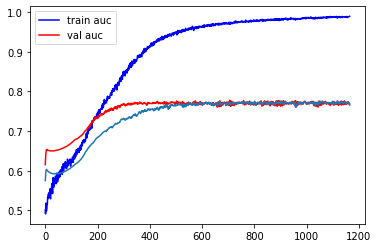

In [54]:
import matplotlib.pylab as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(range(len(train_auc_history)),train_auc_history,'b-',label='train auc')
ax1.plot(range(len(val_auc_history)),val_auc_history,'r-',label='val auc')
ax1.plot(test_auc_history)
ax1.legend()


In [33]:
gcn=myGCN(print_flag=True,early_stopping=False)
_,_,test_auc,_=gcn.fit(adj,features,labels,train_mask,test_mask,learning_rate=p[0],epochs=best_e,weight=p[1],l2_ratio=p[2],dropout=p[3],min_epoch=0,max_train_auc=1)

print('test auc:{}'.format(test_auc[-1]))

True
cuda:0
Epoch 000: Loss 0.7345, TrainAuc 0.5086, ValAuc 0.5034
Epoch 050: Loss 0.6636, TrainAuc 0.6334, ValAuc 0.6154
Epoch 100: Loss 0.6309, TrainAuc 0.6999, ValAuc 0.6615
Epoch 150: Loss 0.6046, TrainAuc 0.7461, ValAuc 0.6836
Epoch 200: Loss 0.5811, TrainAuc 0.774, ValAuc 0.6902
Epoch 250: Loss 0.5622, TrainAuc 0.7979, ValAuc 0.6954
Epoch 300: Loss 0.5377, TrainAuc 0.8196, ValAuc 0.7006
Epoch 350: Loss 0.5353, TrainAuc 0.8377, ValAuc 0.7023
Epoch 400: Loss 0.5024, TrainAuc 0.8546, ValAuc 0.7057
Epoch 450: Loss 0.4643, TrainAuc 0.8698, ValAuc 0.7093
Epoch 500: Loss 0.4764, TrainAuc 0.8808, ValAuc 0.7141
test auc:0.7145622265714944


In [26]:
data=pd.read_csv('./new/RT_SC_B_v2_withKG.csv')
y=data.iloc[:,-1]
X=data.iloc[:,0:-1]
for column in list(X.columns[X.isna().sum() > 0]):
    mean_val = X[column].mean()
    X[column].fillna(mean_val, inplace=True)
adj_matrix=sp.load_npz('./new/RT_SC_B_v2.npz')
X=X.values
from sklearn.preprocessing import minmax_scale
X=minmax_scale(X)
y=financial_featrues['label'].values
adj, features, labels=load_data(X,y,adj_matrix)

Loading {} dataset...
finished


In [39]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
node_num=len(features)
parmas=[]
leanring_rate=[0.0001]
l2=[0.001]
weight=[[1.0,8.0],[1.0,6.0],[1.0,4.0],[1.0,2.0]]
dropout=[0.2,0.1]
iter=itertools.product(leanring_rate,weight,l2,dropout)
train_ids,test_ids=train_test_split(np.array(range(len(features))),stratify=financial_featrues['label'].values,random_state=5,test_size=0.2)
train_mask_row=sample_mask(train_ids,node_num)
train_ids,val_ids=train_test_split(train_ids,test_size=0.25,stratify=financial_featrues['label'].values[train_ids],random_state=5)
test_mask = sample_mask(test_ids, node_num)
train_mask = sample_mask(train_ids, node_num)
val_mask = sample_mask(val_ids, node_num)
test_mask = sample_mask(test_ids, node_num)
val_auc_tmp=[]
re=[]
for p in iter:
    parmas.append(p)
    print(p)
    gcn=myGCN(print_flag=False,early_stopping=True)
    loss_history,train_auc_history,val_auc_history,best_e=gcn.fit(adj,features,labels,train_mask,val_mask,learning_rate=p[0],epochs=4000,
        weight=p[1],l2_ratio=p[2],dropout=p[3],min_epoch=500,max_train_auc=1.0,tolerance=400)
    re.append([best_e,max(val_auc_history)])
best_id=np.argmax([i[1] for i in re])
print('best params{},best epoch:{},best val auc:{}'.format(parmas[best_id],re[best_id][0],re[best_id][1]))
gcn=myGCN(print_flag=False,early_stopping=False)
_,_,test_auc,_=gcn.fit(adj,features,labels,train_mask,test_mask,learning_rate=parmas[best_id][0],epochs=re[best_id][0],weight=parmas[best_id][1],
    l2_ratio=parmas[best_id][2],dropout=parmas[best_id][3],min_epoch=0,max_train_auc=1.0)
print('test auc:{}'.format(test_auc[-1]))

(0.0001, [1.0, 8.0], 0.001, 0.2)
True
cuda:0
(0.0001, [1.0, 8.0], 0.001, 0.1)
True
cuda:0
(0.0001, [1.0, 6.0], 0.001, 0.2)
True
cuda:0
(0.0001, [1.0, 6.0], 0.001, 0.1)
True
cuda:0
(0.0001, [1.0, 4.0], 0.001, 0.2)
True
cuda:0
(0.0001, [1.0, 4.0], 0.001, 0.1)
True
cuda:0
(0.0001, [1.0, 2.0], 0.001, 0.2)
True
cuda:0
(0.0001, [1.0, 2.0], 0.001, 0.1)
True
cuda:0
best params(0.0001, [1.0, 4.0], 0.001, 0.1),best epoch:508,best val auc:0.7408620731034151
True
cuda:0
test auc:0.7218800368408933


In [98]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):
        """图卷积：L*X*\theta
        Args:
        ----------
            input_dim: int
                节点输入特征的维度
            output_dim: int
                输出特征维度
            use_bias : bool, optional
                是否使用偏置
        """
        super(GraphConvolution, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

    def forward(self, adjacency,weight, input_feature):
        """邻接矩阵是稀疏矩阵，因此在计算时使用稀疏矩阵乘法
    
        Args: 
        -------
            adjacency: torch.sparse.FloatTensor
                邻接矩阵
            input_feature: torch.Tensor
                输入特征
        """
        device = "cuda" if torch.cuda.is_available() else "cpu"
        k=0
        weight=weight/weight.sum()
        for adj in adjacency:
            support = torch.mm(input_feature, self.weight.to(device))
            output = torch.sparse.mm(adj, support)
            if self.use_bias:
                output += self.bias.to(device)
            if k==0:
                real_output=output*weight[k]
            else:
                real_output+=output*weight[k]

        return real_output

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

# ## 模型定义
class GcnNet2(nn.Module):
    """
    定义一个包含两层GraphConvolution的模型
    """
    def __init__(self, adj_list,input_dim=343,embed_dim=1024):
        super(GcnNet2, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, embed_dim)
        self.gcn2 = GraphConvolution(embed_dim, embed_dim)
        self.mlp=nn.Linear(embed_dim,embed_dim)
        self.output=nn.Linear(embed_dim,2)
        self.adj_list=adj_list
        self.adj_weight=nn.Parameter(torch.Tensor(len(adj_list)))
        nn.init.constant_(self.adj_weight,1.0)
        self.layer_norm=nn.LayerNorm(normalized_shape= embed_dim)
    def forward(self, feature,drop_out=0.5):
        self.dropout = nn.Dropout(p=drop_out)
        h1 = F.relu(self.dropout(self.gcn1(self.adj_list,self.adj_weight, feature)))
        h2 = F.relu(self.dropout(self.gcn2(self.adj_list,self.adj_weight, h1)))
        h2=self.layer_norm(h2)
        h3=torch.sigmoid(self.dropout(self.mlp(h2)))
        logits=self.output(h3)
        return logits
    def get_adj_weight(self):
        print(self.adj_weight)
        return self.adj_weight
from sklearn.metrics import roc_auc_score
class myGCN2:
    def __init__(self,print_flag=False,early_stopping=True,seed=55):
        self.printFlag=print_flag
        self.early_stopping=early_stopping
        flag = torch.cuda.is_available()
        print(flag)
        ngpu= 1
        # Decide which device we want to run on
        self.device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
        print(self.device)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        pass
    def fit(self,adj_list,features,labels,train_mask,val_mask,test_mask,learning_rate=0.01,epochs=2000,weight=[1.0,2.0],l2_ratio=0.001,
                dropout=0.2,min_epoch=1000,max_train_auc=0.99,min_train_auc=0.90,tolerance=200,embed_dim=1024):
        weight_decay = l2_ratio
        sample_size=features.size()[0]
        feature_size=features.size()[1]
        # 模型定义：Model, Loss, Optimizer
        device = self.device
       
        self.dropout=dropout
        self.tensor_x = features.to(device)
        self.tensor_y = labels.to(device)
        tensor_train_mask = torch.from_numpy(train_mask).to(device)
        tensor_test_mask = torch.from_numpy(test_mask).to(device)
        tensor_val_mask=torch.from_numpy(val_mask).to(device)
        self.tensor_adjacency_list=[]
        for adj in adj_list:
            indices = torch.from_numpy(np.asarray([adj.row, adj.col]).astype('int64')).long()
            values = torch.from_numpy(adj.data.astype(np.float32))
            
            self.tensor_adjacency_list.append(torch.sparse.FloatTensor(indices, values, (sample_size,sample_size)).to(device))
        self.model = GcnNet2(self.tensor_adjacency_list,input_dim=feature_size,embed_dim=embed_dim).to(device)
        self.criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(weight,requires_grad=False).to(device))
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        ###train
        train_loss,train_auc,val_auc,test_auc,best_e,best_val_auc=self.train(tensor_train_mask,tensor_val_mask,tensor_test_mask,epochs,min_epoch,max_train_auc,min_train_auc,tolerance)
        return train_loss,train_auc,val_auc,test_auc,best_e,best_val_auc
    def train(self,tensor_train_mask,tensor_val_mask,tensor_test_mask,epochs,min_epoch=1000,max_train_auc=0.98,min_train_auc=0.95,tolerance=200):
        loss_history = []
        val_auc_history = []
        train_auc_history=[]
        test_auc_history=[]
        self.model.train()
        train_y = self.tensor_y[tensor_train_mask]
        stop_increasing=0
        max_auc=0
        train_auc_min_id=0
        for epoch in range(epochs):
            logits = self.model( self.tensor_x,drop_out=self.dropout)  # 前向传播
            train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
            loss = self.criterion(train_mask_logits, train_y)    # 计算损失值
            self.optimizer.zero_grad()
            loss.backward()     # 反向传播计算参数的梯度
            self.optimizer.step()    # 使用优化方法进行梯度更新
            train_acc, _, _ = self.test(tensor_train_mask,drop_out=self.dropout)     # 计算当前模型训练集上的准确率
            val_acc, _, _ = self.test(tensor_val_mask,drop_out=0.0)     # 计算当前模型在验证集上的准确率
            test_acc, _, _ = self.test(tensor_test_mask,drop_out=0.0) 
            # 记录训练过程中损失值和准确率的变化，用于画图
            loss_history.append(loss.item())
            val_auc_history.append(val_acc.item())
            train_auc_history.append(train_acc.item())
            test_auc_history.append(test_acc.item())
            if train_acc>min_train_auc and train_auc_min_id==0:
                train_auc_min_id=epoch
                print('epoch {} meet the min train auc requirement'.format(epoch))
            if train_acc>=max_train_auc:
                print('train auc meets the setting line:{}'.format(max_train_auc))
                break
            if epoch>min_epoch and val_acc.item()<max_auc:
                stop_increasing+=1
            else:
                max_auc=val_acc.item()
                stop_increasing=0
            if self.early_stopping:
                if stop_increasing>=tolerance:
                    if self.printFlag:
                        print('验证集收敛:epoch {}'.format(epoch))
                    break
            if epoch%100==0 and self.printFlag:
                print("Epoch {:03d}: Loss {:.4f}, TrainAuc {:.4}, ValAuc {:.4f}".format(
                    epoch, loss.item(), train_acc.item(), val_acc.item()))
        if self.early_stopping==True:
            best_e=np.argmax(val_auc_history[min_epoch:])+min_epoch+1
            best_val_auc=max(val_auc_history[min_epoch:])
        else:
            best_e=np.argmax(val_auc_history[train_auc_min_id:])+train_auc_min_id+1
            best_val_auc=max(val_auc_history[train_auc_min_id:])
        self.model.get_adj_weight()
        return loss_history,train_auc_history, val_auc_history,test_auc_history,best_e,best_val_auc
# 测试函数
    def test(self,mask,drop_out=0.1):
        self.model.eval()
        with torch.no_grad():
            logits = self.model(self.tensor_x,drop_out=drop_out)
            test_mask_logits = torch.softmax(logits[mask],dim=1)
            predict_y = test_mask_logits[:,1]
            auc = roc_auc_score(self.tensor_y[mask].cpu().numpy(),predict_y.cpu().numpy())
        return auc, test_mask_logits.cpu().numpy(), self.tensor_y[mask].cpu().numpy()


In [ ]:
adj_list = [normalize_adj(sp.coo_matrix(adj, dtype=np.float32)) for adj in [rpt,sdse,sc]]
node_num=len(features)
train_ids,test_ids=train_test_split(np.array(range(len(features))),stratify=financial_featrues['label'].values,random_state=5,test_size=0.2)
train_mask_row=sample_mask(train_ids,node_num)

train_ids,val_ids=train_test_split(train_ids,test_size=0.25,stratify=financial_featrues['label'].values[train_ids],random_state=5)
test_mask = sample_mask(test_ids, node_num)
train_mask = sample_mask(train_ids, node_num)
val_mask = sample_mask(val_ids, node_num)
# lr,weight,l2_ratio,dropout
p=[0.0001,[1.0,8.0],0.01,0.6,0.99,0.90]
print(p)
gcn=myGCN2(print_flag=True,early_stopping=True)
loss_history,train_auc_history2,val_auc_history2,test_auc_history2,best_e2,best_val_auc2=gcn.fit(adj_list,features,labels,train_mask,val_mask,test_mask,learning_rate=p[0],epochs=3000,weight=p[1],
    l2_ratio=p[2],dropout=p[3],min_epoch=500,max_train_auc=p[4],min_train_auc=p[5],tolerance=500,embed_dim=1200)
print(' params{}, epoch:{},best val auc:{},test auc:{}'.format(p,best_e,best_val_auc2,test_auc_history2[best_e2]))